# Diffusion models

They are generative models. They gradually corrupt the input by adding noise until the input completely becomes noise (forward diffusion) and try to recover the input from noise by training a model to learn the noise added to the input at each time step (reverse diffusion).


# Dataset

MNIST dataset - `70,000` images

# Model - Unet 

A simple Unet (https://amaarora.github.io/2020/09/13/unet.html) is trained to predict the noise added to image(s) at a timestep `t`. A Unet architecture is used since the dimensions of the input (image) and the output (noise) are the same.


The model parameters are shared across time to distinguish the noise added at each timestep `t`. Sinusoidal positional embeddings inspired by Transformer (https://arxiv.org/abs/1706.03762) are used to help the network know at what timestep `t` it is operating.

## Importing necessary libraries

In [1]:
import math
import pickle
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
import matplotlib.animation as animation


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Downloading dataset, applying transforms and preparing dataloader

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 128

transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resizes image
                                transforms.ToTensor(), # Scales data to [0,1]
                                transforms.Lambda(lambda x: (x * 2) - 1)]) # Rescale data to [-1, 1] range
train = datasets.MNIST('../data', train=True, transform=transform, download=True) # 60000 images
test = datasets.MNIST('../data', train=False, transform=transform, download=True) # 10000 images

# Subset of dataset
# train = torch.utils.data.Subset(train, indices=range(len(train)//100))
# test =torch.utils.data. Subset(test, indices=range(len(test)//100))

data = torch.utils.data.ConcatDataset([train, test])

data = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(len(data))

546


## Forward diffusion

### Variance schedule

The noise added at each timestep `t` is determined by the variance schedule `beta_t`. There are different kinds of variance schedule - linear, cosine, quadratic, etc that are fixed (not learned by the model). These variances can also be learned by the model. 

A noisy image that has isotropic gaussian distribution at the final timestep `t = T` can be achieved by setting `t` to a large number and using proper variance schedule

In [3]:
def cosine_variance_schedule(T, s=0.008):
    """
    Cosine variance schedule from paper - https://openreview.net/forum?id=-NEXDKk8gZ

    :params T: number of time steps (int)
    
    Returns beta (variance schedule) of length T
    """
    def f(T):
        t = torch.linspace(0, T, T+1).to(device) # 0-T
        f = torch.cos((t/T + s)/(1+s) * torch.pi/2)**2
        return f 
    
    f_t = f(T)
    alpha_bar = f_t
    beta = 1 - alpha_bar[1:] / alpha_bar[:-1] # beta_1 to beta_T
    
    return torch.clip(beta, 0.0001, 0.999).to(device)

def linear_variance_schedule(T):
    """
    Linear variance schedule from https://arxiv.org/abs/2006.11239
    
    :params T: number of time steps (int)
    
    Returns beta (variance schedule) of length T
    
    """
    return torch.linspace(0.0001, 0.02, T).to(device)

def variance_schedule(T, schedule='linear'):
    if schedule == 'linear':
        return linear_variance_schedule(T)
    elif schedule == 'cosine':
        return cosine_variance_schedule(T)
    else:
        raise ValueError('Wrong schedule')

### Forward diffusion process 

Corrupting image with noise at each timestep `t` (controlled by variance schedule) 

In [4]:
T = 500
def forward_diffusion(x0, t, schedule):
    """
    Math based on https://arxiv.org/abs/2006.11239
    
    :params x0: Input image - shape(batch_size, num_channels, img_size, img_size)
    :params t: time step - shape(batch_size)
    :params schedule: Variance schedule - 'linear' or 'cosine'
    
    Returns image corrupted with noise at a given timestep 
    along with the noise added at that time step
    """
    dim = len(x0.shape)-1
    noise = torch.randn_like(x0)

    beta = variance_schedule(T, schedule)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, 0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)
    
    x = (sqrt_alpha_bar[t].reshape(len(t), *(1,)*dim).to(device) * x0.to(device)) +\
        (sqrt_one_minus_alpha_bar[t].reshape(len(t), *(1,)*dim).to(device) * noise.to(device))
    
    return x.to(device), noise.to(device)

## Data visualization

### Image before forward diffusion

/tmp/ipykernel_1515389/1307632373.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  plt.imshow(train[20][0].T, cmap='gray')


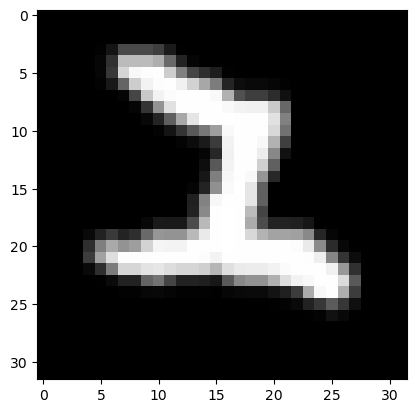

In [6]:
plt.imshow(train[20][0].T, cmap='gray')

### Forward diffusion using Linear variance schedule

Visualizing how noise changes the original image as time progresses using linear variance schedule


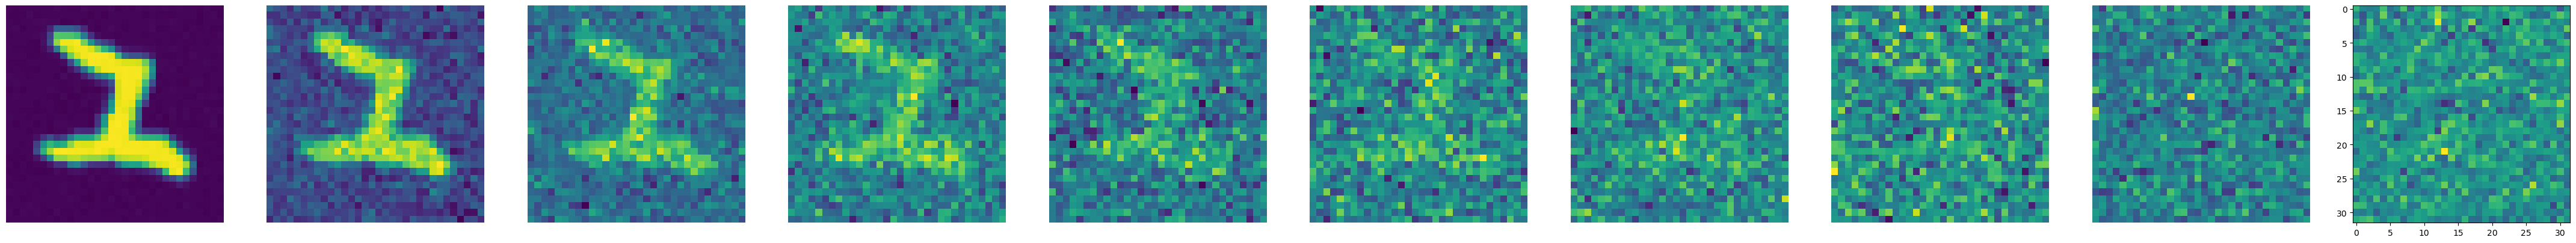

In [7]:
x0 = train[20][0]
plt.figure(figsize=(55,55))

print('Visualizing how noise changes the original image as time progresses using linear variance schedule')
for i in range(T):
    num_images = 10
    step_size = int(T/num_images)
    if i % step_size == 0:
        plt.axis('off')
        plt.subplot(1, num_images, int(i//step_size+1))
        x, _ = forward_diffusion(x0, torch.tensor(i).view(1,-1), 'linear')
        plt.imshow(x.cpu().numpy().T)

### Forward diffusion Cosine variance schedule

Visualizing how noise changes the original image as time progresses using cosine variance schedule


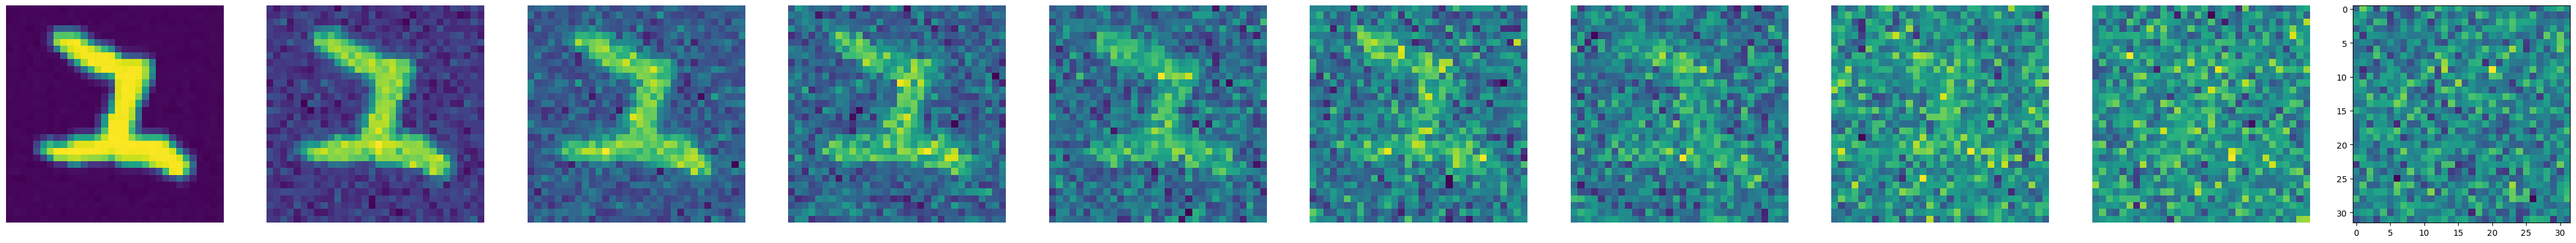

In [8]:
x0 = train[20][0]
plt.figure(figsize=(55,55))
print('Visualizing how noise changes the original image as time progresses using cosine variance schedule')
for i in range(T):
    num_images = 10
    step_size = int(T/num_images)
    if i % step_size == 0:
#         print(i)
        plt.axis('off')
        plt.subplot(1, num_images, int(i//step_size+1))
        x, _ = forward_diffusion(x0, torch.tensor(i).view(1,-1), 'cosine')
        plt.imshow(x.cpu().numpy().T)

## Unet

In [9]:
def positional_encodings(t, dim):
    """
    To enable the model to learn the noise added at each timestep,
    a positional encoding along with the input is fed as input
    
    Reference - https://huggingface.co/blog/annotated-diffusion#position-embeddings
    
    :params t: time steps - a tensor 
    :params dim: encodings dimension - a number (int)
    
    Returns embeddings - shape(len(t), dim)
    """
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim)
    embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
    embeddings = t[:, None] * embeddings[None, :].to(device)
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    # For alternating sine and cosine embeddings
    # Ref - https://stackoverflow.com/questions/71628542/how-to-alternatively-concatenate-pytorch-tensors
    embeddings = embeddings.T.flatten()
    embeddings = torch.stack(torch.split(embeddings, len(t)), dim=1).reshape(len(t),-1)
    
    return embeddings

In [10]:
class Block(nn.ModuleDict):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super(Block, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up: # Upsampling (Decoder)
            self.conv2d1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1) # Same size, half the no. of channels
            self.conv2d2 = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1) # Double size, same no. of channels
            self.conv2dl = torch.nn.Conv2d(out_ch, out_ch, 3, padding=1) # Same size, same no. of channels
        else: # Downsampling (Encoder)
            self.conv2d1 = nn.Conv2d(in_ch, out_ch, 3, padding=1) # Same size, double the no. of channels
            self.conv2d2 = torch.nn.Conv2d(out_ch, out_ch, 3, padding=1) # Same size, same no. of channels
            self.conv2dl = nn.Conv2d(out_ch, out_ch, 4, 2, 1) # Half size, same no. of channels
        self.relu = torch.nn.ReLU()
        self.conv2d3 = torch.nn.Conv2d(out_ch, out_ch, 3, padding=1) # Same size, same no. of channels
        self.conv2d4 = torch.nn.Conv2d(out_ch, out_ch, 3, padding=1) # Same size, same no. of channels
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

    def forward(self, x, t):
        """
        Block performs a series of convolutions that increase/decrease
        the spatial dimension and the number of channels in both 
        downsampling (Encoder) and upsampling (Decoder) stages
        
        :params x: input
        :params t: time embeddings
        """
        c1 = self.bnorm1(self.relu(self.conv2d1(x)))
        
        # Time embedding - 2D
        t_emb = self.relu(self.time_mlp(t)) # shape(batch_size, out_ch)
        # Extend time embedding to 4D like x
        t_emb = t_emb.unsqueeze(2).unsqueeze(3) # shape(batch_size, out_ch, 1, 1)

        c2 = self.relu(self.conv2d2(c1)) # shape(batch_size, out_ch, size, size)
        
        # Add time embedding to up-convolved input
        c2 = c2 + t_emb # shape(batch_size, out_ch, size, size)
        
        c3 = self.bnorm2(self.relu(self.conv2d3(c2)))
        c4 = self.relu(self.conv2d4(c3))
        cl = self.conv2dl(c4)

        return cl

In [11]:
class Encoder(nn.Module):
    def __init__(self, channels=(64, 128, 256, 512, 1024), time_emb_dim=32):
        super(Encoder, self).__init__()
        self.encoder_blocks = nn.ModuleList([Block(channels[c], channels[c+1],
                                                   time_emb_dim) for c in range(len(channels)-1)])

    def forward(self, x, t):
        """
        Encoder doubles the number of channels in the first convolution,
        followed by a series of convolutions that neither change size nor no. of channels,
        halves the input size (spatial dimension) at the final convolution
        and saves the outputs to concatenate during upsampling. 
        It is repeated until the number of channels reaches max. no. of channels
        
        :params x: input, shape(batch_size, enc[0], original i/p size, original i/p size)
        :params t: time embeddings, shape(batch_size, self.tim_dim)
        
        Returns output, shape(batch_size, enc[-1], size/len(enc), size/len(enc)) and a list of encoder o/ps
        """
        enc_ops = []
        for b, block in enumerate(self.encoder_blocks):
            x = block(x, t)
            enc_ops.append(x) # Save encoder o/p
    
        return x, enc_ops

In [12]:
class Decoder(nn.Module):
    def __init__(self, channels=(1024, 512, 256, 128, 64), time_emb_dim=32):
        super(Decoder, self).__init__()
        self.channels = channels
        self.decoder_blocks = nn.ModuleList([Block(channels[i], channels[i+1],
                                                   time_emb_dim, up=True) for i in range(len(channels)-1)])

    def forward(self, x, enc_ops, t):
        """
        Decoder halves the number of channels in the first convolution step,
        doubles the input size in the second convolution step,
        followed by a series of convolutions that neither change size nor no. of channels.
        It is repeated until the number of channels reaches min. no. of channels
        
        :params x: final encoder output, shape(batch_size, enc[-1], size/len(enc), size/len(enc))
        :params enc_ops: list of encoder outputs
        :params t: time embeddings, shape(batch_size, self.tim_dim)
        
        Returns output, shape(batch_size, dec[-1], original i/p size, original i/p size)
        """
        for i in range(len(self.channels)-1):
            enc = enc_ops[i]
            x = torch.cat((enc, x), 1) # Concatenate encoder o/p (on channels dim, so doubles the no. of channels)
            x = self.decoder_blocks[i](x, t)

        return x

In [13]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        enc_ch=(64, 128, 256, 512, 1024) # Encoder channels
        dec_ch=(1024, 512, 256, 128, 64) # Decoder channels
        image_channels = 1 # Number of i/p channels
        self.tim_dim = 256 # time embedding dimension

        # Time embedding
        self.time_mlp = nn.Sequential(
                                      nn.Linear(self.tim_dim, self.tim_dim),
                                      nn.ReLU()
                                      )

        self.conv0 = nn.Conv2d(image_channels, enc_ch[0], 3, padding=1) # 3 channels to enc[0] channels
        self.encoder = Encoder(channels=enc_ch, time_emb_dim=self.tim_dim)
        self.decoder = Decoder(channels=dec_ch, time_emb_dim=self.tim_dim)
        self.conv1 = nn.Conv2d(dec_ch[-1], image_channels, 3, padding=1) # dec[-1] channels to 3 channels

    def forward(self, x, timestep):
        """
        Initial convolution - 3 channels to enc[0] channels,
        followed by encoder and decoder operations and
        final convolution - dec[-1] channels to 3 channels
        
        :params x: images at specific time steps, with(t=1toT)/without(t=0) noise added,
                   shape(batch_size, channels, img_size, img_size)
        :params timestep: a tensor of time steps, shape(batch_size)
        
        Returns noise (predicted) at specific timesteps shape(x)
        """
        # Time embeddings
        t = positional_encodings(timestep, self.tim_dim)
        t = self.time_mlp(t) # shape(batch_size, self.tim_dim)

        # Initial convolution
        x = self.conv0(x)
        # Encoder / down-sampling
        res, enc_ops = self.encoder(x, t)
        # Decoder / Up-sampling
        out = self.decoder(res, enc_ops[::-1], t)
        
        # Final convolution - Set output channels to desired number
        out = self.conv1(out)
        return out # shape(x)

### Check network i/ps and o/ps

In [14]:
x = torch.randn(4,1,64,64).to(device)
t = torch.randint(0, 100, (4,)).long().to(device)
unet = Unet().to(device)
unet(x, t).shape

torch.Size([4, 1, 64, 64])

## Model training

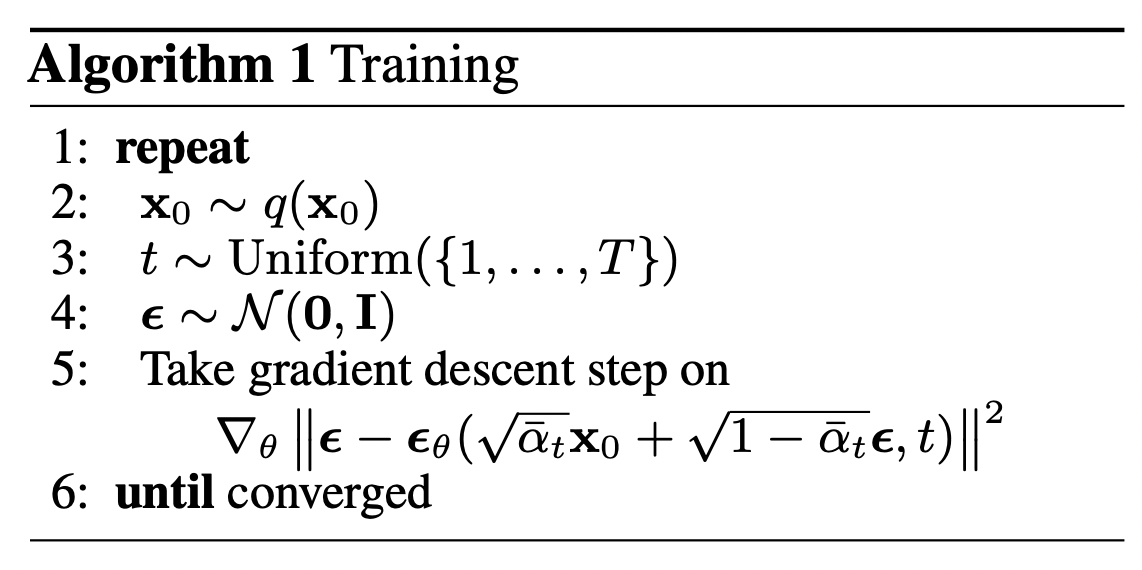

In [13]:
LR = 1e-4 # Learning rate
EPOCHS = 40
unet = Unet().to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)
T = 1000
print(T)
for epoch in range(EPOCHS):
    for step, batch in enumerate(data):
        optimizer.zero_grad()
        
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long().to(device)

        x_noisy , true_noise = forward_diffusion(batch[0].to(device), t, schedule='linear')
        predicted_noise = unet(x_noisy.to(device), t)
        loss = F.l1_loss(predicted_noise, true_noise)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 1 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")

1000
Epoch 0 | step 000 Loss: 0.810745894908905 
Epoch 1 | step 000 Loss: 0.10835292935371399 
Epoch 2 | step 000 Loss: 0.08377598971128464 
Epoch 3 | step 000 Loss: 0.08694227039813995 
Epoch 4 | step 000 Loss: 0.07157929241657257 
Epoch 5 | step 000 Loss: 0.06894706934690475 
Epoch 6 | step 000 Loss: 0.06419388949871063 
Epoch 7 | step 000 Loss: 0.06882691383361816 
Epoch 8 | step 000 Loss: 0.06195715069770813 
Epoch 9 | step 000 Loss: 0.062466949224472046 
Epoch 10 | step 000 Loss: 0.06220715865492821 
Epoch 11 | step 000 Loss: 0.062128856778144836 
Epoch 12 | step 000 Loss: 0.060077130794525146 
Epoch 13 | step 000 Loss: 0.05349523574113846 
Epoch 14 | step 000 Loss: 0.057496316730976105 
Epoch 15 | step 000 Loss: 0.06198651343584061 
Epoch 16 | step 000 Loss: 0.05396725982427597 
Epoch 17 | step 000 Loss: 0.061500586569309235 
Epoch 18 | step 000 Loss: 0.05492119491100311 
Epoch 19 | step 000 Loss: 0.052621111273765564 
Epoch 20 | step 000 Loss: 0.05630391091108322 
Epoch 21 | ste

In [14]:
# # Save model for future use
file_name = 'lin_1000T_conv2dt_256temb'
pickle.dump(unet, open(file_name, 'wb'))

## Sampling

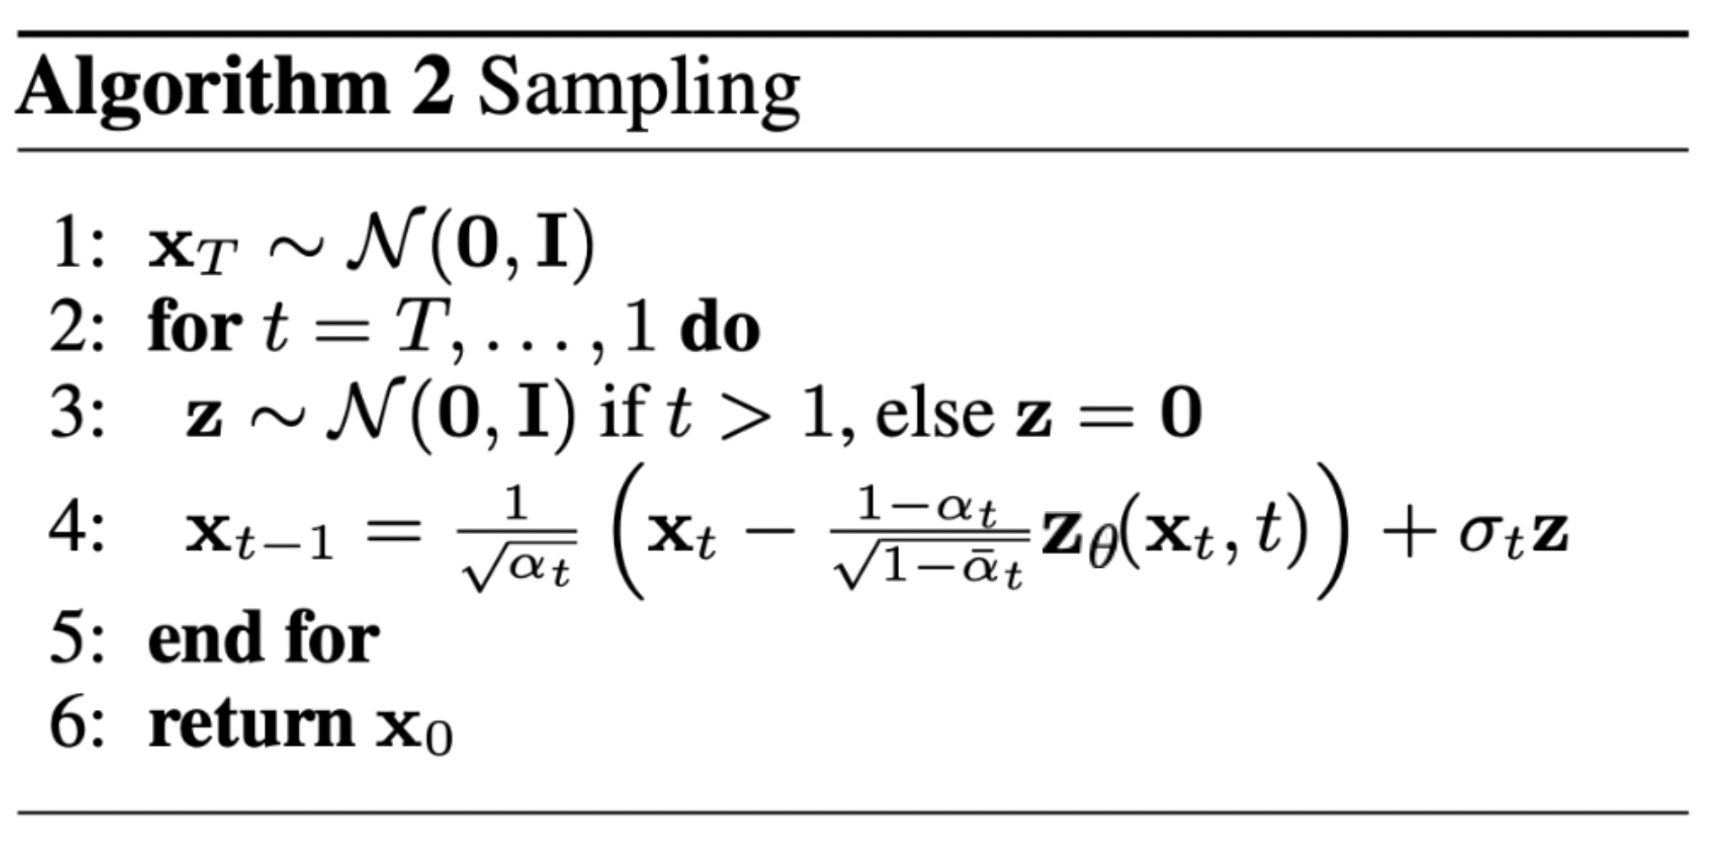

In [15]:
@torch.no_grad()
def sampling(xt, t, unet, schedule):
    """
    Uses trained model to gradually denoise the noisy image (at t) and
    recover image (at t-1)
    
    :params xt: noisy image at timestep t # shape(batch_size, channels, img_size, img_size)
    :params t: timesteps, a tensor # shape(batchsize)
    :params unet: Trained model
    :params schedule: Variance schedule
    
    Returns image at timestep t-1
    """
    noise = torch.randn_like(xt)
    
    beta = variance_schedule(T, schedule=schedule)
    alpha = 1 - beta
    one_minus_alpha = 1 - alpha
    alpha_bar = torch.cumprod(alpha, 0)
    alpha_bar_prev = torch.cat([torch.tensor([1]).cuda(), alpha_bar[:-1]], 0) #concat 1 in the beginning to match size
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)
    variance = ((1 - alpha_bar_prev) / (1 - alpha_bar)) * beta

    mean = (1 / torch.sqrt(alpha[t])) * (xt - (beta[t]/sqrt_one_minus_alpha_bar[t])*unet(xt, t)) 
    
    if t[0] == 0:
        return mean
    else:
        x_prev = mean + torch.sqrt(variance[t]) * noise
        return x_prev

### Load saved model

In [16]:
filename = 'linear_300T'
unet = pickle.load(open(filename, 'rb')).to(device)

### Visualize reverse diffusion process

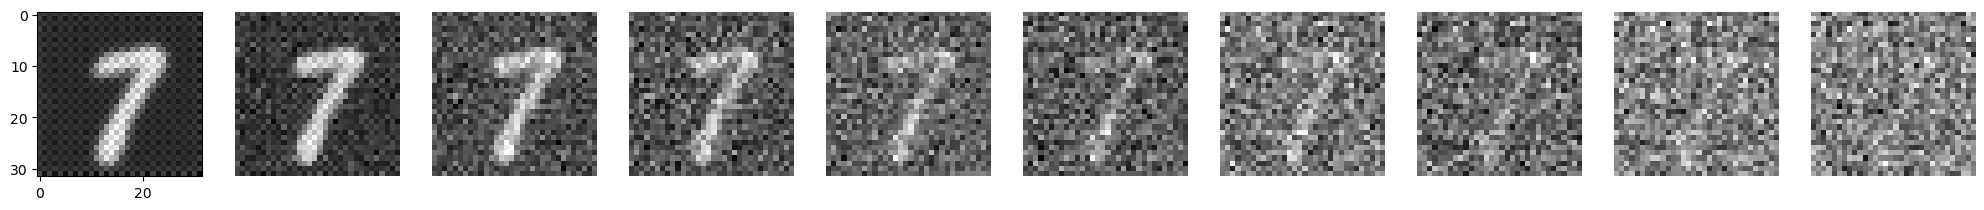

In [34]:
T = 300
xt = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(device)
plt.figure(figsize=(25,25))
num_images = 10
stepsize = int(T//num_images)

for t in range(T-1, -1, -1):
    t = torch.full((1,), t, device=device, dtype=torch.long)
    xt = sampling(xt, t, unet, 'linear')
    if t % stepsize == 0:
        plt.axis('off')
        plt.subplot(1, num_images, int(torch.div(t, stepsize, rounding_mode='trunc'))+1)
        plt.imshow(xt[0,0].detach().cpu().numpy(), cmap='gray')

In [35]:
@torch.no_grad()
def sample_loop(model, T, batch_size):
    """
    Returns a list of denoised images from t=T to t=0
    
    :params model: A trained model
    :params T: timesteps (integer)
    :params batch_size: Batch size
    """
    xt = torch.randn(batch_size, 1, IMG_SIZE, IMG_SIZE).to(device)
    imgs = []
    for t in range(T-1, -1, -1):
        t = torch.full((batch_size,), t, device=device, dtype=torch.long)
        xt = sampling(xt, t, unet, 'linear')
        imgs.append(xt.cpu().numpy())
    return imgs

### Create a gif of reverse diffusion process

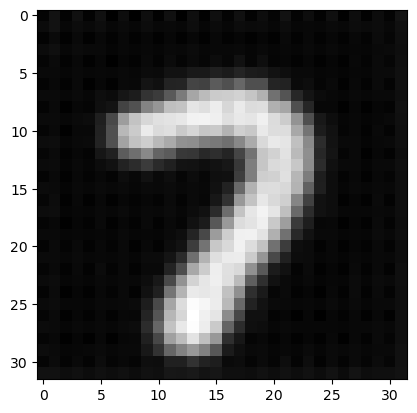

In [37]:
samples = sample_loop(unet, T, 32)
random_index = 23

fig = plt.figure()
ims = []
for i in range(T):
    im = plt.imshow(samples[i][random_index].reshape(IMG_SIZE, IMG_SIZE, 1), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

# References

Denoising diffusion probablitistic models (DDPM) - https://arxiv.org/abs/2006.11239

Improved Denoising diffusion probablitistic models - https://openreview.net/forum?id=-NEXDKk8gZ

Speed-up sampling using Denoising diffusion implicit model (DDIM) - https://arxiv.org/abs/2010.02502

Unet - https://amaarora.github.io/2020/09/13/unet.html

Positional encoding - https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

Diffusion models -

https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

https://huggingface.co/blog/annotated-diffusion

https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=BIc33L9-uK4q